# Homework 2 - Data Science with CO2

__Hand-in__:

- __Due: 07.04.2020 23:59 CET__
- `git push` your final verion to your group's Renku repository before the due
- check if `Dockerfile`, `environment.yml` and `requirements.txt` are properly written
- add necessary comments and discussion to make your codes readable

## Description of the project:

   In this assignment, we will curate a set of **CO2 measurements**, measured from cheap but inaccurate sensors, that have been deployed in the city of Zurich. The goal of the exercise is twofold: 

1. Learn how to deal with real world sensor timeseries data, and organize them efficiently using python dataframes.

2. Apply data science tools to model the measurements, and use the learned model to process them (e.g., detect outliers and drifts in the sensor measurements). 

The sensor network consists of 46 sites, located in different parts of the city. Each site contains three different sensors measuring (a) **CO2 concentration**, (b) **temperature**, and (c) **humidity**. Beside these measurements, we have the following additional information that can be used to process the measurements: 

1. The **altitude** at which the CO2 sensor is located, and the GPS coordinates (latitude, longitude).

2. A clustering of the city of Zurich in 17 different city zones and the **zone** in which the sensor belongs to. Some characteristic zones are industrial area, residential area, forest, glacier, lake, etc.

Given this knowledge, you are asked to define an algorithm that curates the data, by detecting and removing potential drifts. The algorithm should be based on the fact that sensors in similar conditions are expected to have similar measurements. 

## Prior knowledge:
    
The average value of the CO2 in a city is approximately 400 ppm. However, the exact measurement in each site depends on parameters such as the temperature, the humidity, the altitude, and the level of traffic around the site. For example, sensors positioned in high altitude (mountains) and exposed to stronger winds, are expected to have a much lower and uniform level of CO2 than sensors that are positioned in a business area with much higher traffic activity. Moreover, we know that there is a strong dependence of the CO2 measurements on temperature and humidity.


### To start with: 

The following csv files will be needed which can be found in the `../data/` folder: 

1. `CO2_sensor_measurements.csv`
    
   __Description__: It containts the CO2 measurements (CO2), the name of the site (LocationName), a unique sensor identifier (SensorUnit_ID), and the time instance in which the measurement was taken (timestamp).
    
2. `temperature_humidity.csv`

   __Description__: It contains the temperature and the humidity measurements for each sensor identifier, at each timestamp (Timestamp). For each SensorUnit_ID, the temperature and the humidity can be found in the corresponding columns of the dataframe (SensorUnit_ID.temperature, SensorUnit_ID.humidity).
    
3. `sensor_metadata_updated.csv`

   __Description__: It contains the name of the site (LocationName), the zone index (zone), the altitude in meters, and longitude, latitude. 

Import the following python packages:

In [2]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import statsmodels.api as sm
import array
import os
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

### PART I: Handling time series with pandas (10 points)

a) **8/10** Merge the `CO2_sensor_measurements.csv`, `temperature_humidity.csv`, and `sensors_metadata.csv`, into a single dataframe like this:

| timestamp | LocationName | SensorUnit_ID | CO2 | temperature | humidity | zone | altitude | lon | lat |
|:---------:|:------------:|:-------------:|:---:|:-----------:|:--------:|:----:|:--------:|:---:|:---:|
|    ...    |      ...     |      ...      | ... |     ...     |    ...   |  ... |    ...   | ... | ... |

The merged dataframe contains as index the time instance (timestamp) of the measurements, and columns the location of the site (LocationName), the sensor ID (SensorUnit_ID), the CO2 measurement, the temperature, the humidity, the zone, the altitude, the longitude and the latitude. For each measurement, take the average over an interval of 30 min. If there are missing measurements, interpolate them linearly from measurements that are close by in time.

__Hints__: The following methods could be useful

1. ```python 
pandas.DataFrame.resample()
``` 
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.resample.html
    
2. ```python
pandas.DataFrame.interpolate()
```
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.interpolate.html
    
3. ```python
pandas.DataFrame.mean()
```
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.mean.html
    
4. ```python
pandas.DataFrame.append()
```
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.append.html

In [3]:
# load data
co2 = pd.read_csv('../data/CO2_sensor_measurements.csv', sep = '\t')
temp_humid = pd.read_csv('../data/temperature_humidity.csv', sep = '\t')
meta = pd.read_csv('../data/sensors_metadata_updated.csv')

display(co2.head())
display(temp_humid.head())
display(meta.head())

,timestamp,LocationName,SensorUnit_ID,CO2
0,2017-10-01 00:05:00,ZGHD,1014,593.321562
1,2017-10-01 00:15:00,ZGHD,1014,595.846258
2,2017-10-01 00:25:00,ZGHD,1014,595.845353
3,2017-10-01 00:45:00,ZGHD,1014,599.039129
4,2017-10-01 00:55:00,ZGHD,1014,594.996629


,Timestamp,1014.temperature,1014.humidity,1015.temperature,1015.humidity,1016.temperature,1016.humidity,1017.temperature,1017.humidity,1018.temperature,...,1291.temperature,1291.humidity,1292.temperature,1292.humidity,1297.temperature,1297.humidity,1298.temperature,1298.humidity,1299.temperature,1299.humidity
0,2017-10-01 00:00:00,11.39,92.262787,10.55,91.949982,11.02,92.613739,11.05,89.811844,11.38,...,10.13,96.828979,10.50,95.858139,10.70,94.524902,11.35,90.288681,11.44,90.118927
1,2017-10-01 00:10:00,11.39,92.579407,10.48,92.079681,11.04,93.063873,11.05,90.042633,11.38,...,10.12,97.322983,10.45,95.903915,10.53,94.395203,11.35,90.422195,11.46,90.073151
2,2017-10-01 00:20:00,11.41,92.480225,10.51,92.583221,11.06,93.201202,11.02,89.888138,11.35,...,10.14,97.780746,10.43,95.343155,10.45,94.620270,11.33,91.023010,11.41,89.466614
3,2017-10-01 00:30:00,11.35,91.902298,10.55,92.714828,11.02,92.932266,10.96,89.790863,11.31,...,10.13,97.904724,10.43,95.322174,10.42,94.973129,11.32,91.019196,11.39,89.249176
4,2017-10-01 00:40:00,11.30,91.639084,10.59,92.764420,10.99,92.598480,10.95,89.821381,11.27,...,10.13,97.931427,10.48,96.451324,10.46,95.282120,11.28,90.443176,11.31,88.871521


,Unnamed: 0,LocationName,zone,altitude,LAT,LON,X,Y
0,0,AJGR,2,627.8,47.33321,8.480300,243005.0,678731.4
1,1,BSCR,2,462.3,47.35581,8.430070,245468.0,674903.4
2,2,BUDF,10,490.2,47.36270,8.433110,246237.5,675123.8
3,3,KBRL,7,510.5,47.32582,8.537550,242242.3,683070.1
4,4,KTGM,2,530.3,47.32334,8.596422,242031.0,687523.9


In [4]:
# check if any missing values in co2 table
co2.isnull().any()

timestamp        False
LocationName     False
SensorUnit_ID    False
CO2              False
dtype: bool

In [5]:
# set timestamp as table index
co2['timestamp'] = pd.to_datetime(co2['timestamp'])
temp_humid['Timestamp'] = pd.to_datetime(temp_humid['Timestamp'])
co2.set_index('timestamp', inplace = True)
temp_humid.set_index('Timestamp', inplace = True)

# create a map between location and sensor ID
location_ID_dict = {}
for location in co2.LocationName.unique():
    location_ID_dict[location] = co2[co2['LocationName'] == location].SensorUnit_ID.unique()[0]

In [6]:
# downsampling the co2 table to co2_curated
# For each measurement, the average over an interval of 30 min is taken
co2_curated = pd.DataFrame(columns = co2.columns)
for location in co2['LocationName'].unique():
    co2_loc = co2[co2['LocationName'] == location]['CO2']
    downsample = co2_loc.resample('30T').mean()
    temp = pd.DataFrame({'LocationName': location, 'SensorUnit_ID': location_ID_dict[location], 'CO2': downsample})
    co2_curated = co2_curated.append(temp)
co2_curated = co2_curated.reset_index().rename(columns = {'index': 'timestamp'})
co2_curated.tail()

,timestamp,LocationName,SensorUnit_ID,CO2
66662,2017-10-31 21:30:00,ZLDW,1299,477.307329
66663,2017-10-31 22:00:00,ZLDW,1299,474.396830
66664,2017-10-31 22:30:00,ZLDW,1299,474.406102
66665,2017-10-31 23:00:00,ZLDW,1299,477.910252
66666,2017-10-31 23:30:00,ZLDW,1299,471.881151


In [7]:
# check if any missing values in the temp_humid table
temp_humid.isnull().any()

1014.temperature    True
1014.humidity       True
1015.temperature    True
1015.humidity       True
1016.temperature    True
                    ... 
1297.humidity       True
1298.temperature    True
1298.humidity       True
1299.temperature    True
1299.humidity       True
Length: 92, dtype: bool

In [8]:
# linearly interpolate missing values in temp_humid table
temp_humid.interpolate('linear',axis=0,inplace=True)

# downsampling the temp_humid table to temp_humid_curated
# For each measurement, the average over an interval of 30 min is taken
temp_humid_curated = pd.DataFrame(columns = ['SensorUnit_ID', 'temperature', 'humidity'])
temp_humid_resampled = temp_humid.resample('30T').mean()
for location in co2['LocationName'].unique():
    sensor_id = location_ID_dict[location]
    temp = temp_humid_resampled[str(sensor_id) + '.' + 'temperature']
    humid = temp_humid_resampled[str(sensor_id) + '.' + 'humidity']
    temp_humid_curated = temp_humid_curated.append(pd.DataFrame({'SensorUnit_ID': sensor_id, 'temperature': temp, 'humidity': humid}))
temp_humid_curated = temp_humid_curated.reset_index().rename(columns = {'index': 'timestamp'})
temp_humid_curated.tail()

,timestamp,SensorUnit_ID,temperature,humidity
68443,2017-10-31 21:30:00,1299,3.923333,78.965388
68444,2017-10-31 22:00:00,1299,3.766667,79.702896
68445,2017-10-31 22:30:00,1299,3.493333,80.769740
68446,2017-10-31 23:00:00,1299,3.373333,81.676366
68447,2017-10-31 23:30:00,1299,3.286667,81.910970


In [9]:
# merge all
data = co2_curated.merge(temp_humid_curated, how = 'outer', on = ['timestamp', 'SensorUnit_ID'])
data = data.merge(meta.iloc[:, 1:-2], on = 'LocationName')
data.tail()

,timestamp,LocationName,SensorUnit_ID,CO2,temperature,humidity,zone,altitude,LAT,LON
66662,2017-10-31 21:30:00,ZLDW,1299.0,477.307329,3.923333,78.965388,5,405.9,47.34887,8.53629
66663,2017-10-31 22:00:00,ZLDW,1299.0,474.396830,3.766667,79.702896,5,405.9,47.34887,8.53629
66664,2017-10-31 22:30:00,ZLDW,1299.0,474.406102,3.493333,80.769740,5,405.9,47.34887,8.53629
66665,2017-10-31 23:00:00,ZLDW,1299.0,477.910252,3.373333,81.676366,5,405.9,47.34887,8.53629
66666,2017-10-31 23:30:00,ZLDW,1299.0,471.881151,3.286667,81.910970,5,405.9,47.34887,8.53629


In [10]:
# check if any missing values
data.isnull().any()

timestamp        False
LocationName     False
SensorUnit_ID    False
CO2               True
temperature      False
humidity         False
zone             False
altitude         False
LAT              False
LON              False
dtype: bool

In [11]:
# linearly interpolate missing values
data['CO2'] = data['CO2'].interpolate()
# change index of final table to timestamp
data.set_index('timestamp', inplace = True)
data.SensorUnit_ID = data.SensorUnit_ID.astype(int)
data.tail()

,LocationName,SensorUnit_ID,CO2,temperature,humidity,zone,altitude,LAT,LON
timestamp,,,,,,,,,
2017-10-31 21:30:00,ZLDW,1299,477.307329,3.923333,78.965388,5,405.9,47.34887,8.53629
2017-10-31 22:00:00,ZLDW,1299,474.396830,3.766667,79.702896,5,405.9,47.34887,8.53629
2017-10-31 22:30:00,ZLDW,1299,474.406102,3.493333,80.769740,5,405.9,47.34887,8.53629
2017-10-31 23:00:00,ZLDW,1299,477.910252,3.373333,81.676366,5,405.9,47.34887,8.53629
2017-10-31 23:30:00,ZLDW,1299,471.881151,3.286667,81.910970,5,405.9,47.34887,8.53629


In [12]:
# check if any missing values
data.isnull().any()

LocationName     False
SensorUnit_ID    False
CO2              False
temperature      False
humidity         False
zone             False
altitude         False
LAT              False
LON              False
dtype: bool

b) **2/10** Export the curated and ready to use timeseries to a csv file. 

In [13]:
# Save the final table to csv file
data.to_csv('../data/data_curated.csv')

### PART II: Data visualization (15 points)

a) **5/15** Group the sites based on their altitude, by performing K-means clustering. Find the optimal number of clusters using the [Elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)). Write out the formula of metric you intend to use for Elbow curve. Add an additional column to the dataframe of the previous question indicating the altitude cluster index. 

__Note__: [Yellowbrick](http://www.scikit-yb.org/) is a very nice Machine Learning Visualization extension to scikit-learn, which might be useful to you. 

In [14]:
# Load curated data from csv
data = pd.read_csv('../data/data_curated.csv')
data['timestamp'] = pd.to_datetime(data['timestamp'])
data.set_index('timestamp',inplace=True)
data.head()

,LocationName,SensorUnit_ID,CO2,temperature,humidity,zone,altitude,LAT,LON
timestamp,,,,,,,,,
2017-10-01 00:00:00,ZGHD,1014,595.004391,11.396667,92.440806,2,413.5,47.370446,8.523256
2017-10-01 00:30:00,ZGHD,1014,597.017879,11.303333,91.625097,2,413.5,47.370446,8.523256
2017-10-01 01:00:00,ZGHD,1014,596.487010,11.240000,91.096761,2,413.5,47.370446,8.523256
2017-10-01 01:30:00,ZGHD,1014,598.787639,11.260000,91.275734,2,413.5,47.370446,8.523256
2017-10-01 02:00:00,ZGHD,1014,595.366394,11.285000,91.003937,2,413.5,47.370446,8.523256


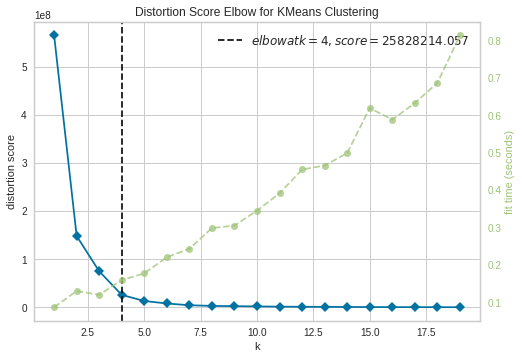

In [15]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

# Instantiate the clustering model and visualizer
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 20))

# Generate Elbow, this takes seconds to run
visualizer.fit(data['altitude'].values.reshape(-1, 1))
visualizer.show()
plt.show()

The metric used for the elbow curve is inertia, which is the sum of squared distance of samples to their closest cluste centers.

Given a set of samples X , and a set of k clusters C with centroids U , inertia is
defined as 
$$\displaystyle\sum_{i=1}^{k} \sum_{x \in C_i} \|x - u_i\|^2$$

In [16]:
# Elbow indicates 4 as the optimal number of clusters
model_opt = KMeans(n_clusters = 4)
model_opt.fit(data['altitude'].values.reshape(-1, 1))
data['altitude cluster index'] = model_opt.labels_

b) **3/15** Plot the monthly median CO2 measurement for each site with respect to the altitude. Annotate each point of the plot with the name of the location (LocatioName), and give the same color to stations that belong to the same altitude  cluster.    

In [17]:
# Prepare the table with monthly median CO2 measurement
monthly_median_co2_loc = pd.DataFrame(columns = ['CO2 Median', 'LocationName', 'altitude', 'altitude cluster index'])
for location in data.LocationName.unique():
    monthly_median_co2 = data[data.LocationName == location]['CO2'].resample('M').median()
    cluster_index = data[data.LocationName == location]['altitude cluster index'].unique()[0]
    altitude = data[data.LocationName == location]['altitude'].unique()[0]
    monthly_median_co2_loc = monthly_median_co2_loc.append(pd.DataFrame({'CO2 Median': monthly_median_co2, 'LocationName': location, 'altitude': altitude, 'altitude cluster index': cluster_index}))
    
monthly_median_co2_loc.head()

,CO2 Median,LocationName,altitude,altitude cluster index
2017-10-31,614.545051,ZGHD,413.5,0
2017-10-31,481.059336,ZORL,439.9,0
2017-10-31,466.948569,ZTBN,402.9,0
2017-10-31,439.161697,ZHRG,410.5,0
2017-10-31,448.509612,ZSCH,413.1,0


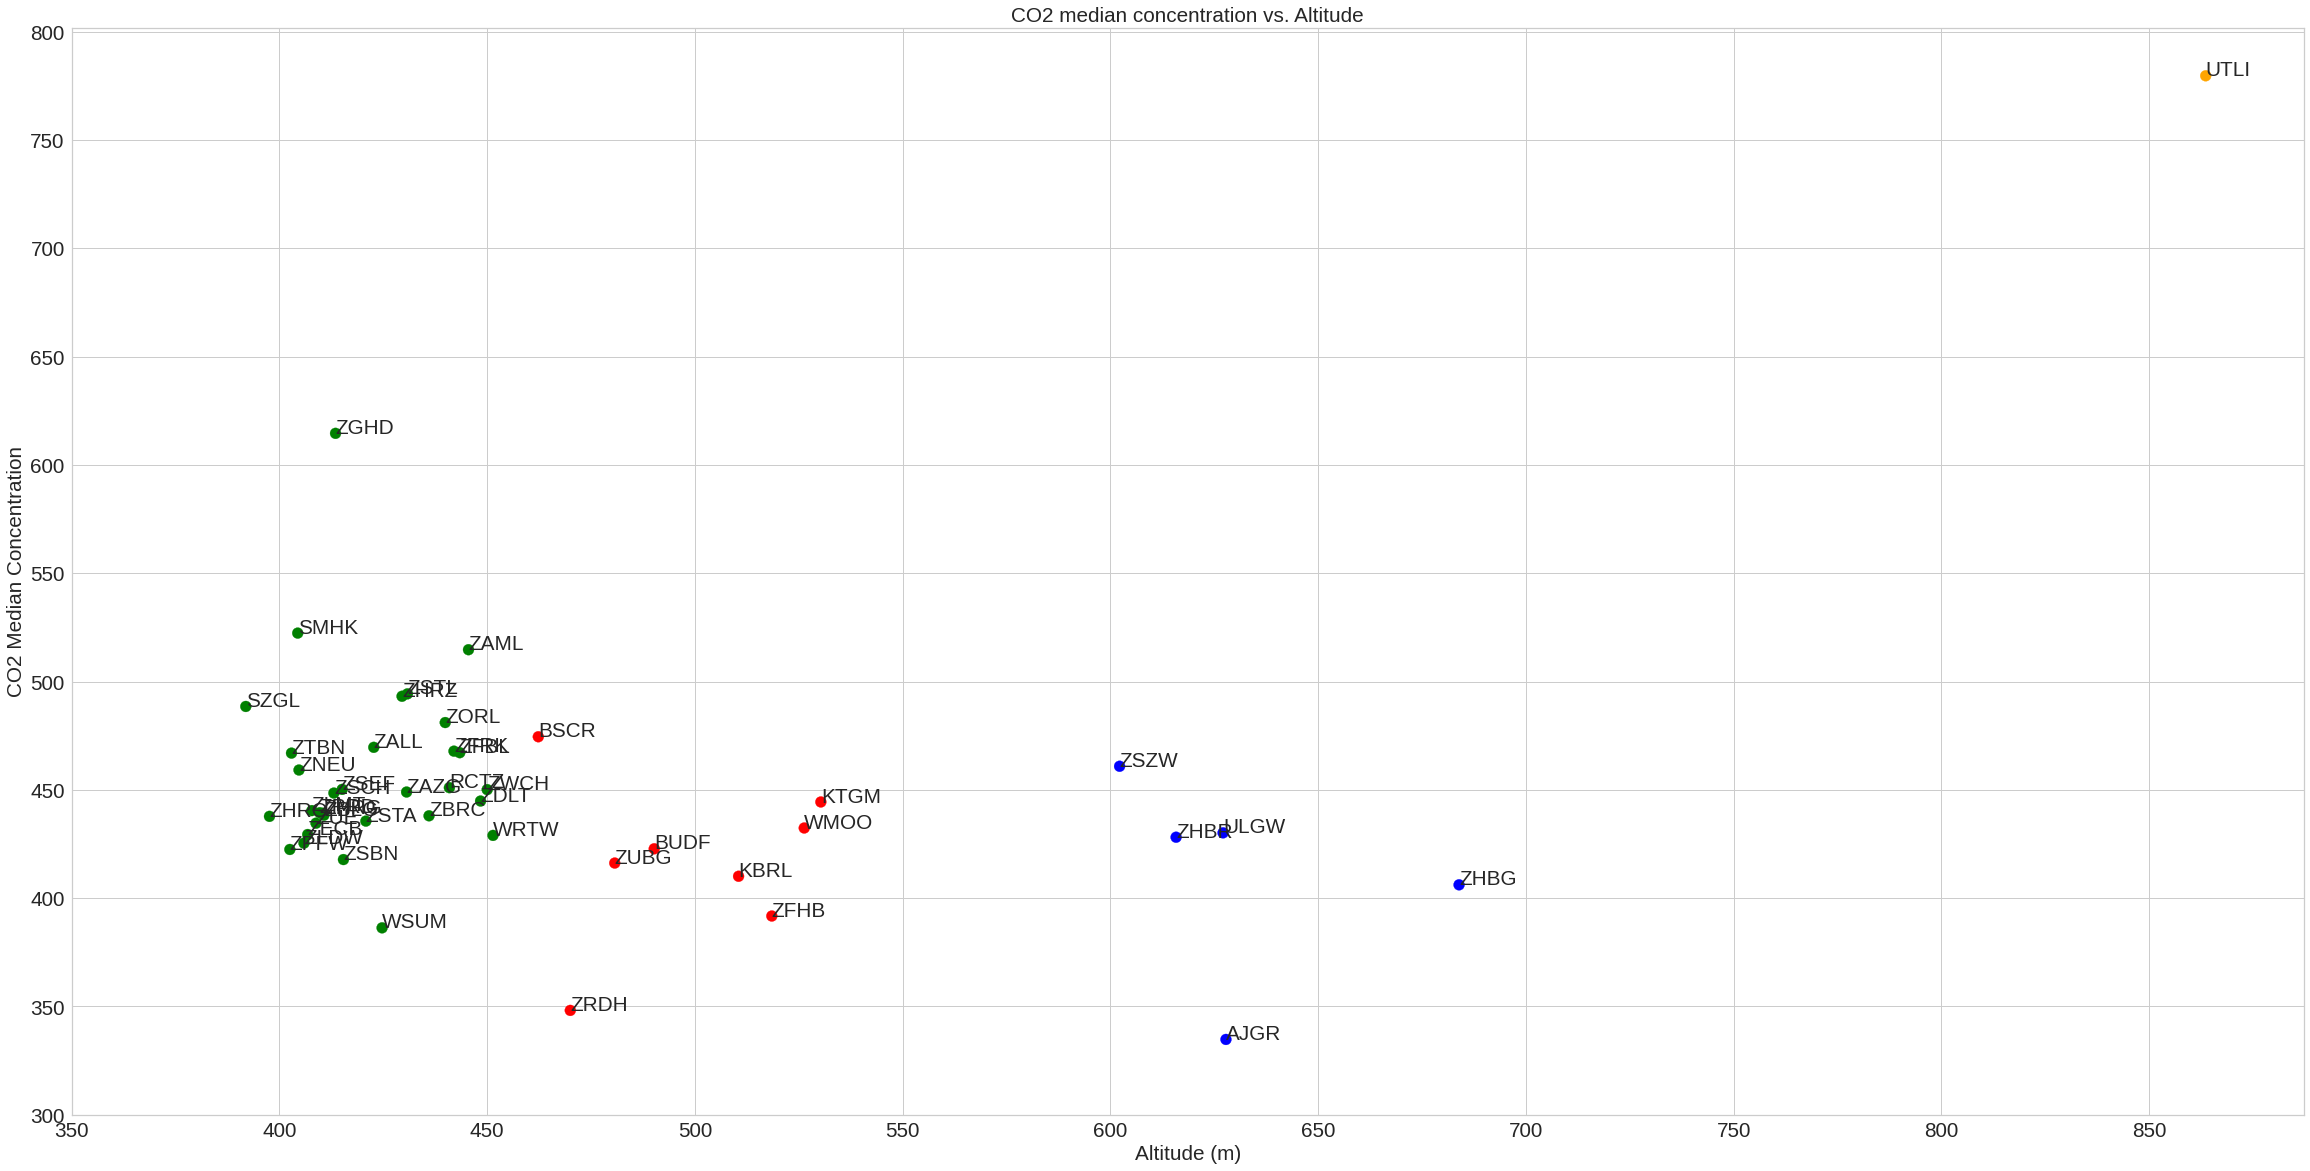

In [18]:
# Plot
import matplotlib.colors

cmap = matplotlib.colors.ListedColormap(['green', 'blue', 'orange', 'red'])
ax = monthly_median_co2_loc.plot(x = 'altitude', y = 'CO2 Median', kind = 'scatter', figsize = (40, 20),
                            c = 'altitude cluster index', colormap = cmap, colorbar=False, s=120)

for k, v in monthly_median_co2_loc.iterrows():
    plt.annotate(v['LocationName'], (v['altitude'], v['CO2 Median']), fontsize='xx-large')

plt.ylabel('CO2 Median Concentration', fontsize='xx-large')
plt.xlabel('Altitude (m)', fontsize='xx-large')
plt.title('CO2 median concentration vs. Altitude', fontsize='xx-large')
plt.xticks(np.arange(350, 900, 50), fontsize='xx-large')
plt.yticks(np.arange(300, 850, 50), fontsize='xx-large')

plt.show()

c) **7/15** Plot the stations on an interactive Zurich map, and dispay their location name. And, on the same map, plot a time-varying heatmap of the mean daily CO2 concentration for all the stations.

__Note__: You can use the python library [Folium](https://python-visualization.github.io/folium/) for that, but any other visualization tools can be used.

In [19]:
import folium

In [147]:
# Prepare the table with monthly mean CO2 measurement
daily_mean_co2_loc = pd.DataFrame(columns = ['CO2_Mean', 'LocationName','lat','lon'])
for location in data.LocationName.unique():
    daily_mean_co2 = data[data.LocationName == location]['CO2'].resample('D').mean()
    lat = data[data.LocationName == location]['LAT'].values[0]
    lon = data[data.LocationName == location]['LON'].values[0]
    daily_mean_co2_loc = daily_mean_co2_loc.append(pd.DataFrame({'CO2_Mean': daily_mean_co2, 'LocationName': location,'lat':lat,'lon':lon}))
    
daily_mean_co2_loc.head()

,CO2_Mean,LocationName,lat,lon
2017-10-01,601.634340,ZGHD,47.370446,8.523256
2017-10-02,602.992140,ZGHD,47.370446,8.523256
2017-10-03,585.072627,ZGHD,47.370446,8.523256
2017-10-04,616.758988,ZGHD,47.370446,8.523256
2017-10-05,602.447857,ZGHD,47.370446,8.523256


In [148]:
# scale the weight in range(0,1) for plot
# daily_mean_co2_loc['CO2_Mean'] = np.log(daily_mean_co2_loc['CO2_Mean'])
max_co2 = daily_mean_co2_loc.describe().loc['max']['CO2_Mean']
min_co2 = daily_mean_co2_loc.describe().loc['min']['CO2_Mean']
diff = max_co2 - min_co2
daily_mean_co2_loc['weight'] = (daily_mean_co2_loc['CO2_Mean'] - min_co2) / diff

In [161]:
# auto play
# Run the cell to let it play, alternatively you can use the saved html in the root folder (map_HeatMapwithTime.html)
# Click the blue location symbols to show location names

# the tool labels on the bottom-left seems broken, but they will show up if you hover the mouse over them
from folium import plugins
m = folium.Map(
    location=[47.366667,8.55],
    zoom_start=13
)

tooltip = 'Click me!'

for loc in daily_mean_co2_loc['LocationName'].unique():
    tmp = daily_mean_co2_loc[daily_mean_co2_loc['LocationName'] == loc]
    lat = tmp['lat'].values[0]
    lon = tmp['lon'].values[0]
    folium.Marker(
        [lat, lon],
        popup=loc,
        tooltip=tooltip
    ).add_to(m)

times = [x.strftime("%Y-%m-%d") for x in daily_mean_co2_loc.index.unique()]
map_data = []
for time in daily_mean_co2_loc.index.unique():
    daily_data = []
    tmp = daily_mean_co2_loc.loc[time][['LocationName','lat','lon','CO2_Mean','weight']]
    for loc in tmp['LocationName'].unique():
        tmp2 = tmp[tmp['LocationName'] == loc]
        lat = tmp2['lat'].values[0]
        lon = tmp2['lon'].values[0]
        weight = tmp2['weight'].values[0]
        daily_data.append([lat,lon,weight])
    map_data.append(daily_data)

plugins.HeatMapWithTime(
    data = map_data,
    index = list(range(1,32)),
    radius = 65,
    max_opacity=0.8,
    use_local_extrema= False,
    gradient={0.2:'blue',0.25: 'yellow',0.3:'orange',0.4:'red'},
    auto_play=True
    
).add_to(m)

m.save("../map_HeatMapwithTime.html")
m

### PART III: Model fitting for data curation (35 points)

a) __3/35__ How to handle missing data matters in real-world data science project. Although here we have all the data, it is still a very good opportunity for you to learn. Let's assume there is one site `KBRL` which somehow lost all the CO2 data of `2017-10-04`. Compare different ways of interpolating for the missing values (in time: linear interpolation and cubic interpolation, in space: using other sensors in the same altitude cluster) and plot the interpolation results. Use the data you have as the ground truth to discuss your findings.

In [23]:
# extract data from the site KBRL
data_kbrl = data[data['LocationName'] == 'KBRL']

# set CO2 concentration to be null on 2017-10-04
data_kbrl.loc['2017-10-04', 'CO2'] = None
data_kbrl.loc['2017-10-04', :].head()

,LocationName,SensorUnit_ID,CO2,temperature,humidity,zone,altitude,LAT,LON,altitude cluster index
timestamp,,,,,,,,,,
2017-10-04 00:00:00,KBRL,1176,NaN,10.596667,76.635880,7,510.5,47.32582,8.53755,3
2017-10-04 00:30:00,KBRL,1176,NaN,10.680000,76.431157,7,510.5,47.32582,8.53755,3
2017-10-04 01:00:00,KBRL,1176,NaN,10.526667,77.201726,7,510.5,47.32582,8.53755,3
2017-10-04 01:30:00,KBRL,1176,NaN,9.960000,77.628337,7,510.5,47.32582,8.53755,3
2017-10-04 02:00:00,KBRL,1176,NaN,9.270000,80.417516,7,510.5,47.32582,8.53755,3


In [24]:
# linearly interpolate null values by time
data_kbrl1 = data_kbrl.copy()
data_kbrl1['CO2'] = data_kbrl1['CO2'].interpolate()

# cubically interpolate by time
data_kbrl2 = data_kbrl.copy()
data_kbrl2['CO2'] = data_kbrl2['CO2'].interpolate(method = 'cubic')

In [25]:
# extract data with the same cluster as the one in KBRL
data_kbrl_same_cluster = data[data['altitude cluster index'] == data_kbrl['altitude cluster index'].unique()[0]]
data_kbrl_same_cluster = data_kbrl_same_cluster[data_kbrl_same_cluster['LocationName'] != 'KBRL']

# make CO2 null on 2017-10-04 in KBRL
data_kbrl_same_cluster = data_kbrl_same_cluster.append(data_kbrl)

# make a pivot table
data_kbrl_same_cluster = data_kbrl_same_cluster.reset_index().rename(columns = {'index': 'timestamp'})
data_kbrl_same_cluster_pivot = data_kbrl_same_cluster.pivot(index = 'timestamp', columns = 'LocationName', values = 'CO2')
data_kbrl_same_cluster_pivot['2017-10-04'].head()

LocationName,BSCR,BUDF,KBRL,KTGM,WMOO,ZFHB,ZRDH,ZUBG
timestamp,,,,,,,,
2017-10-04 00:00:00,478.421906,441.106219,NaN,440.832233,412.668673,397.958818,335.302152,403.316102
2017-10-04 00:30:00,493.304606,443.815683,NaN,443.396817,416.685879,395.097655,338.522046,404.418625
2017-10-04 01:00:00,486.507921,438.205134,NaN,446.335042,427.196293,392.162252,340.148295,406.646319
2017-10-04 01:30:00,479.272364,445.246770,NaN,445.371729,442.788703,394.253918,339.563632,408.108502
2017-10-04 02:00:00,480.743326,440.550505,NaN,445.450016,439.639129,392.061725,346.896316,406.556517


In [26]:
 # choose row mean to replace null values
data_kbrl_same_cluster_pivot1 = data_kbrl_same_cluster_pivot.copy()
data_kbrl_same_cluster_pivot1 = data_kbrl_same_cluster_pivot1.apply(lambda row: row.fillna(row.mean()), axis=1)

# choose row median to replace null values
data_kbrl_same_cluster_pivot2 = data_kbrl_same_cluster_pivot.copy()
data_kbrl_same_cluster_pivot2 = data_kbrl_same_cluster_pivot2.apply(lambda row: row.fillna(row.median()), axis=1)

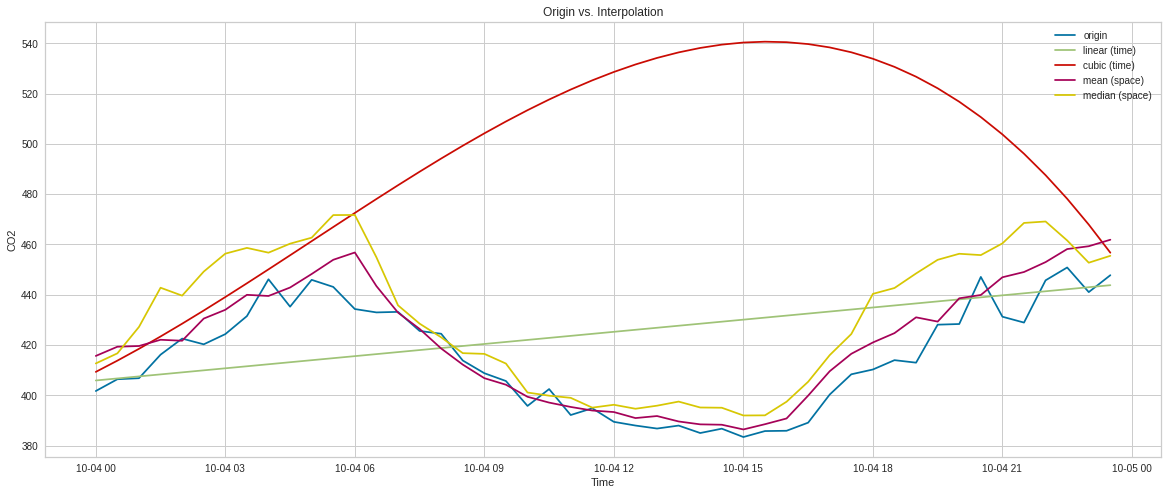

In [27]:
 # plot
plt.figure(figsize = (20, 8))
plt.plot(data[data['LocationName'] == 'KBRL'].loc['2017-10-04', 'CO2'], label = 'origin')
plt.plot(data_kbrl1.loc['2017-10-04', 'CO2'], label = 'linear (time)')
plt.plot(data_kbrl2.loc['2017-10-04', 'CO2'], label = 'cubic (time)')
plt.plot(data_kbrl_same_cluster_pivot1.loc['2017-10-04', 'KBRL'], label = 'mean (space)')
plt.plot(data_kbrl_same_cluster_pivot2.loc['2017-10-04', 'KBRL'], label = 'median (space)')
plt.xlabel('Time')
plt.ylabel('CO2')
plt.title('Origin vs. Interpolation')
plt.legend()
plt.show()

#### Explaination: 

- From the plot, data interpolated by cubic and linear mostly deviate from ground truth and is obviously infeasible. 
- Especially with cubic method, CO2 shows a different trend from the orignal data along time series, which should decrease after 6 a.m. but increase dramatically. 
- Compared to them, interploating data with median and mean fit the original data better. 
- In particular, mean works better than median in this case with less point-wise differnce in general. This may be because in reality, CO2 concentration generally stays in a range at a particular time of a day. But basically, median is actually a better choice if we do not know the distribution of original data since it is a robust statistic and the outlier exists in the data (the one in UTLI form 2b).

b) **2/35** The technician in charge of these sensors reported that one of the CO2 sensors `ZSBN` is exhibiting a drift on Oct. 21. Verify the drift by visualizing the CO2 concentration of the drifting sensor and some other sensors from the network. 

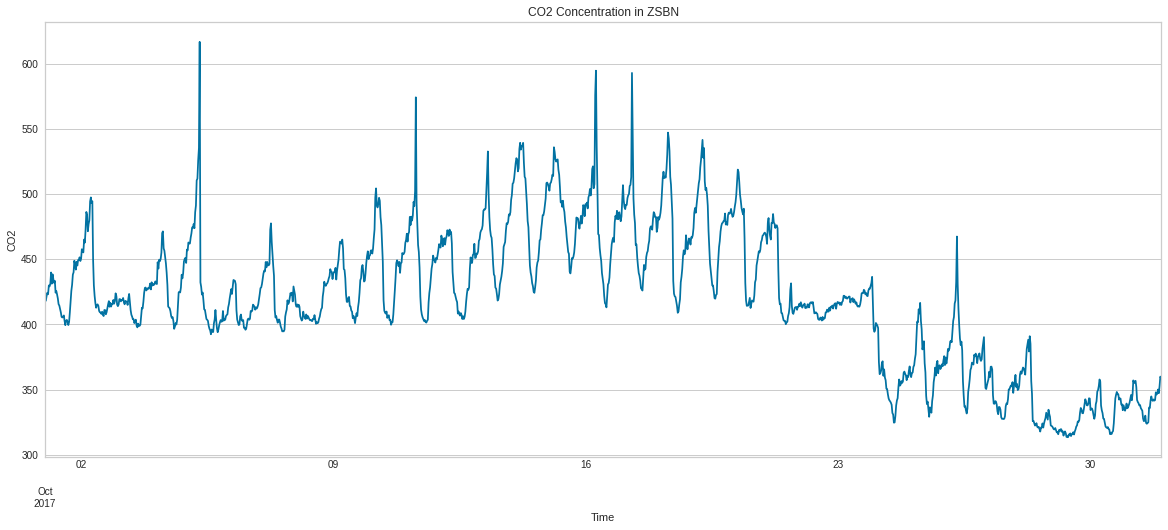

In [28]:
 # extract data from the site, ZSBN
data_zsbn = data[data['LocationName'] == 'ZSBN']

# visualize the CO2 concentration of the sensor
data_zsbn.loc[:, 'CO2'].plot(figsize = (20, 8))
plt.xlabel('Time')
plt.ylabel('CO2')
plt.title('CO2 Concentration in ZSBN')
plt.show()

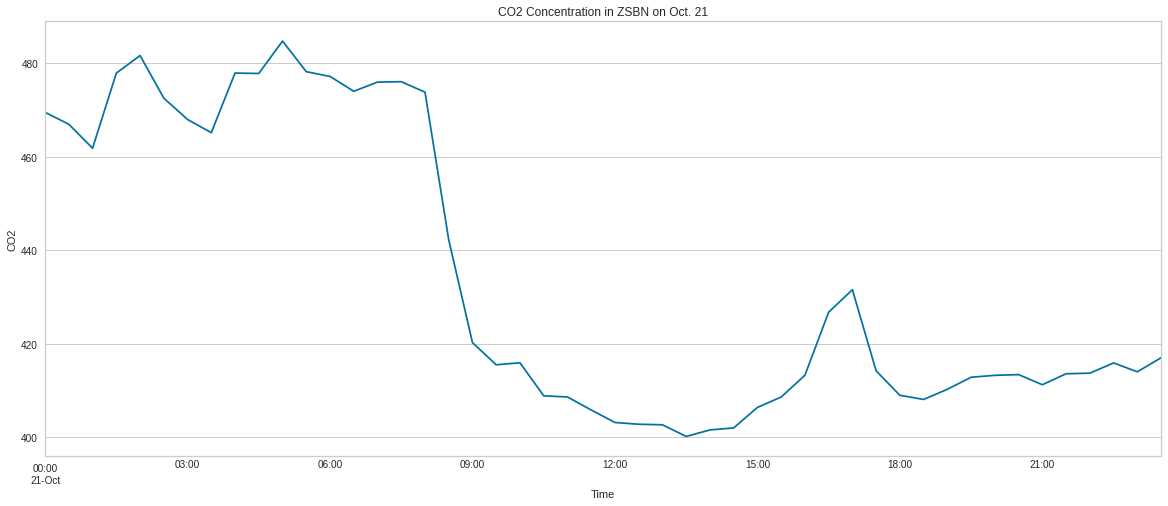

In [29]:
# take a closer look
# visualize the CO2 concentration of the sensor
data_zsbn.loc['2017-10-21', 'CO2'].plot(figsize = (20, 8))
plt.xlabel('Time')
plt.ylabel('CO2')
plt.title('CO2 Concentration in ZSBN on Oct. 21')
plt.show() 

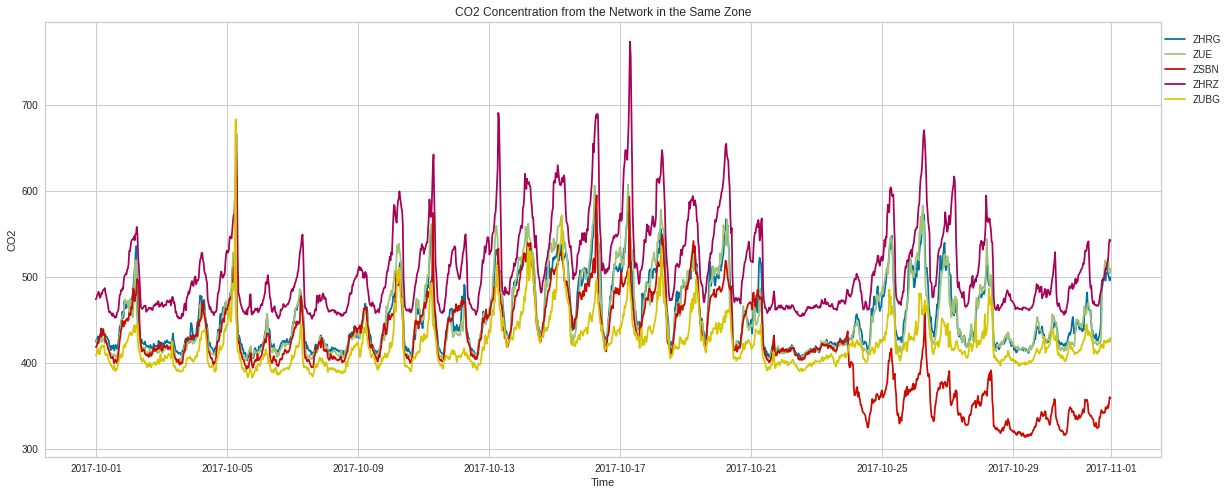

In [30]:
 # take all sensors in the same cluster as the one in ZSBN into account
data_zsbn_same_cluster = data[data['zone'] == data_zsbn['zone'].unique()[0]]
plt.figure(figsize = (20, 8))
for location in data_zsbn_same_cluster.LocationName.unique():
    # change of CO2 concentration in ZRDH will make the obeservation in ZSBN harder to distinguish, so we exclude this location in the plot.
    if location != 'ZRDH':
        co2_loc = data_zsbn_same_cluster[data_zsbn_same_cluster['LocationName'] == location].loc[:, 'CO2']
        plt.plot(co2_loc, label = location)
    
plt.xlabel('Time')
plt.ylabel('CO2')
plt.title('CO2 Concentration from the Network in the Same Zone')
plt.legend(loc = (1, 0.8))
plt.show()

#### Explaination: 
- From the two plots above, it shows that all sensors in the same zone have similar changing trend except the one in ZSBN after OCT. 23. 
- Epecially, we can obeserve that data of ZSBN shows a obivous deviation on around 10-23 since it had similar concentration with ZHRG and ZUE before but dropped obviously on that day. 
- Therefore, the drift may occur on Oct 23 rather than Oct 21 or the sensor occur the drift on Oct 21 but the environment didn't change a lot until Oct 23.

c) **6/35** We want to reconstruct the CO2 concentration of the drifting sensor had the drift not happened. Train a forecasting model on the CO2 values of the drifting sensor. Use linear regression with features the past CO2 values over an interval of 3 hours (past 6 observations), mathematically, $C_t \sim h(C_{t-1}, C_{t-2}, C_{t-3}, C_{t-4}, C_{t-5}, C_{t-6})$, where $C_i$ is the CO2 value at time $i$.

Plot and compare the actual CO2 measurements, and the values obtained by the prediction of the linear model for the entire month of October, together with their confidence interval obtained from cross validation. What do you observe? 

__Note__: 
1. Cross validation on time series is different from that on other kinds of datasets. scikit-learn provides a nice method for you, `sklearn.model_selection.TimeSeriesSplit`. For more on time series cross validation, there are a lot of interesting articles available online.
2. Think about how to make prediction on data before the drift and after the drift. What's the difference?

In [31]:
data['timestamp']= pd.to_datetime(data.index)

# take all data prior october as the training 
train_indexing = (data['timestamp'].dt.date < pd.to_datetime('2017-10-21')) & (data['LocationName'] == 'ZSBN') 
X = [data[train_indexing]['CO2'].to_list()[i:i+6] for i in range(len(data[train_indexing])-6)]
X = np.array(X)
y = [data[train_indexing]['CO2'].to_list()[i] for i in range(6,len(data[train_indexing]))]
y = np.array(y)

# take the whole october month as the test set
test_indexing=(pd.to_datetime('2017-10-20')<data['timestamp'].dt.date)&(data['LocationName']=='ZSBN') 
#take the last six measurements priori the 21th october as X_test
X_test=np.array(data[train_indexing]['CO2'].to_list()[-6:])

y_true=data[test_indexing][['timestamp','CO2']].to_numpy()

In [32]:
from sklearn import linear_model
from sklearn.model_selection import TimeSeriesSplit

# set up split mechanism
tscv = TimeSeriesSplit()
scores=[]
# cross validation and use linear regression with l1 regularization
for train_index, val_index in tscv.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    lasso = linear_model.Lasso().fit(X_train,y_train) 
    scores.append(lasso.score(X_val, y_val))

scores=np.array(scores)

In [33]:
# make prediction after 10-21
y_pred1 = np.array([])

# make prediction according to previous prediction after 10-21 as there is no accurate observation 
while len(y_pred1) < len(y_true):
    X_test = np.reshape(X_test[-6:], (1, -1))
    pred = lasso.predict(X_test)
    y_pred1 = np.append(y_pred1,pred)
    X_test = np.append(X_test,pred)
    
results = pd.DataFrame(y_true,y_pred1).reset_index().rename(columns = {0:'timestamp', 1:'true', 'index':'pred1'})\
[['timestamp','pred1','true']].set_index('timestamp')
results.head()

,pred1,true
timestamp,,
2017-10-21 00:00:00,469.399409,469.545
2017-10-21 00:30:00,468.216070,466.991
2017-10-21 01:00:00,466.933813,461.869
2017-10-21 01:30:00,465.660628,477.921
2017-10-21 02:00:00,464.262813,481.693


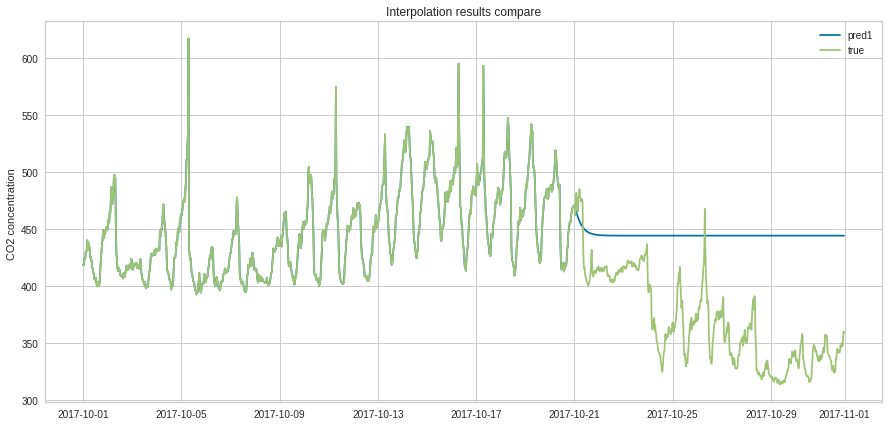

In [34]:
prev_data = data[train_indexing][['timestamp','CO2']].rename(columns = {'CO2':"pred1"}).set_index('timestamp')
prev_data['true'] = prev_data['pred1']

# plot
to_plot=pd.concat([prev_data,results])
plt.figure(figsize=(15,7))
plt.ylabel("CO2 concentration ")
plt.title("Interpolation results compare")
plt.plot(to_plot)
plt.legend(to_plot.columns)
plt.show()

#### Explaination: 

- The prediction seems to work very bad as the CO2 concentration doesn't have any change after a particular moment on Oct 21. It is obviously wrong prediction. 
- This may be because it makes an incorrect prediction without accurate measurement at the begining. 
- After that, this wrong prediction will result in another incorrect prediction and undermine the following predictions eventually.

d) **3/35** Train a second forecasting model on the CO2 values of the drifting sensor. In this step, use __current__ values of temperature and humidity as features,  as well as their __past__ values over the same interval of three hours, mathematically, $C_t \sim h(T_{t}, \cdots, T_{t-6}, H_{t}, \cdots, H_{t - 6})$, where $T_i$ and $H_i$ are temperature and humidity at time $i$. Plot and compare the actual CO2 measurements, the values obtained by the prediction of the linear model for the entire month of October, together with their confidence interval obtained from cross validation. Are you able to remove the drift? If yes, how, if no, why?

In [37]:
 def build_data_local(indexing):
    """
    Build training and testing dataset
    
    Arg:
        indexing(pandas.series): a series in boolean type, True if corresponding index is selected, False otherwise.
    """
    X1=[data[indexing]['temperature'].to_numpy()[i:i+7] for i in range(len(data[indexing])-6)]
    X2=[data[indexing]['humidity'].to_numpy()[i:i+7] for i in range(len(data[indexing])-6)]
    X1=np.array(X1)
    X2=np.array(X2)
    X=np.concatenate([X1,X2],axis=1)
    return X

def add_6_at_head(test_indexing):
    """
    Make the last 6 measurement prior to Oct 21 to test set, as they are not included in the training data before
    Arg:
        test_indexing(pandas.series): a series in boolean type, True if corresponding index is selected, False otherwise.
    """
    endloc = list(test_indexing.values).index(True)
    test_indexing.iloc[endloc-6:endloc]=True
    return test_indexing

In [156]:
#prepare train data
X = build_data_local(train_indexing)
y = [data[train_indexing]['CO2'].to_numpy()[i] for i in range(6,len(data[train_indexing]))]
y = np.array(y)

# prepare test data
test_indexing2 = test_indexing
test_indexing2 = add_6_at_head(test_indexing2)
X_test = build_data_local(test_indexing)

In [157]:
# set up split mechanism
tscv = TimeSeriesSplit()
scores = []
# cross validation and use linear regression with l1 regularization
for train_index, val_index in tscv.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    lasso = linear_model.Lasso().fit(X_train,y_train)
    scores.append(lasso.score(X_val, y_val))

scores=np.array(scores)
print("R sqaure: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

R sqaure: 0.03 (+/- 0.79)


In [158]:
scores

array([ 0.24252046,  0.60539076, -0.05234053, -0.59795712, -0.02589899])

In [140]:
# prediction
y_pred2 = lasso.predict(X_test)
results = pd.DataFrame(y_true,y_pred2).reset_index().rename(columns={0:'timestamp',1:'true','index':'pred2'})\
[['timestamp','pred2','true']].set_index('timestamp')
results.head()

,pred2,true
timestamp,,
2017-10-21 00:00:00,450.794983,469.545
2017-10-21 00:30:00,451.625284,466.991
2017-10-21 01:00:00,451.535748,461.869
2017-10-21 01:30:00,452.121525,477.921
2017-10-21 02:00:00,450.593048,481.693


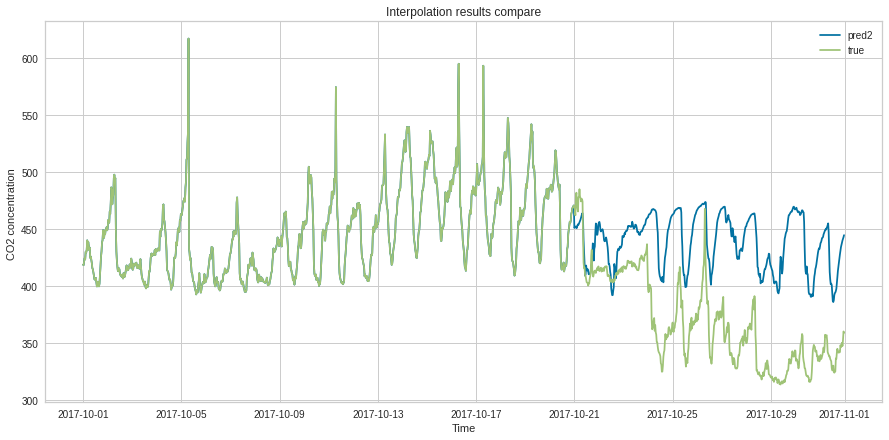

In [141]:
prev_data=data[train_indexing][['timestamp','CO2']].rename(columns={'CO2':"pred2"}).set_index('timestamp')
prev_data['true']=prev_data['pred2']

# plot
to_plot=pd.concat([prev_data,results])
plt.figure(figsize=(15,7))
plt.xlabel("Time")
plt.ylabel("CO2 concentration ")
plt.title("Interpolation results compare")
plt.plot(to_plot)
plt.legend(to_plot.columns)
plt.show()

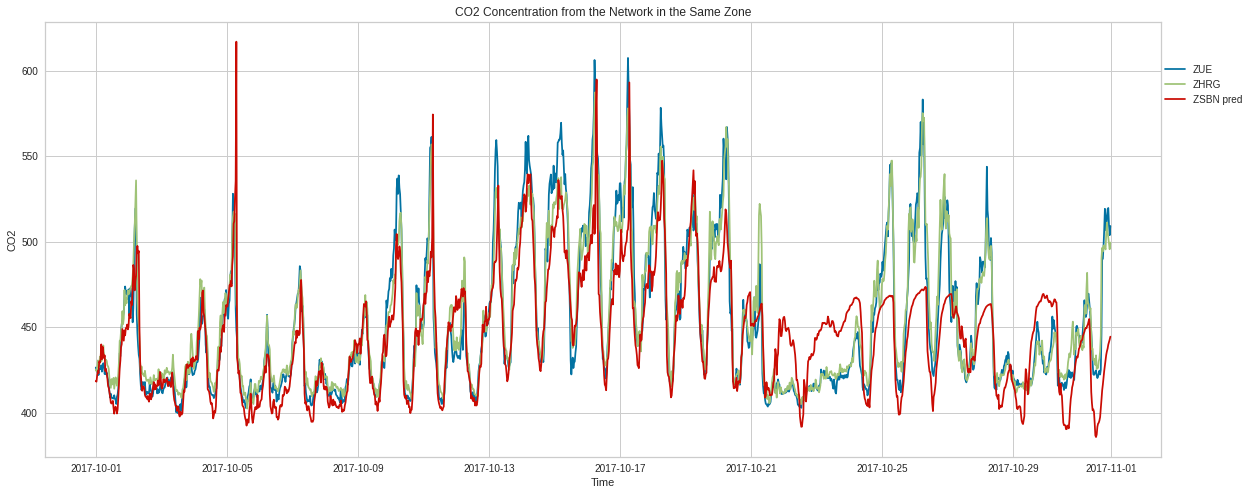

In [142]:
# compare with other sensors which have similar co2 concentration to ZSBN
data_zsbn_same_cluster = data[data['zone'] == data_zsbn['zone'].unique()[0]]
plt.figure(figsize = (20, 8))
for location in ['ZUE','ZHRG']:
    co2_loc = data_zsbn_same_cluster[data_zsbn_same_cluster['LocationName'] == location].loc[:, 'CO2']
    plt.plot(co2_loc, label = location)
    
plt.plot(to_plot.loc[:,'pred2'],label='ZSBN pred')
# plt.plot(to_plot.loc[:,'true'],label='ZSBN true',color='pink')
plt.xlabel('Time')
plt.ylabel('CO2')
plt.title('CO2 Concentration from the Network in the Same Zone')
plt.legend(loc = (1, 0.8))
plt.show()

#### Explaination: 
- Result shows that confidence interval lies in a wide range (+/- 0.79) with small mean. However, despite the similar periodic oscillation of the model, it still can not well predict the exact CO2 value at most of the time. Only a general tendency is catched by this model, which leads to a very low R squared value.
- However, compared to 3c, the prediction shows a periodic change through the whole day rather than keep decreasing and the CO2 concentration is almost higher than 400 which seems to be reasonable. 
- Therefore, we think the drift can be removed because the prediction measurements is in reasonable CO2 concentration range and have a similar trend with the other sensors in the same zone. 
- Compared to ZUE and ZHRG, the predicted ZSBN data doesn't fit their trend so well. It seems to climb up smoothly to every peak with less flutuation.

e) **6/35** Build another linear regression model by exploting the fact that the CO2 concentrations, as measured by the sensors __experiencing similar conditions__, are expected to be similar. Apply the learned model to the drifting sensor, and plot the results. Discuss your findings.

Learn a model on other sensors: $ C_t^{S} \sim h(T_{t}^{S}, \cdots, T_{t - 6}^{S}, H_{t}^{S}, \cdots, H_{t - 6}^{S})$, where $S$ is the cluster of sensors experiencing similar conditions like ZSBN.

Apply the model on ZSBN to see if the drift has been removed: $\hat{C}_t^{ZSBN} = h(T_{t}^{ZSBN}, \cdots, T_{t - 6}^{ZSBN}, H_{t}^{ZSBN}, \cdots, H_{t - 6}^{ZSBN})$


As mentioned before, sensors in the same zones with ZSBN shows similar changing trend. In particular for ZUE and ZHRG, these two senesors even shows similar concentration to ZSBN every moment. Therefore, we choose sensor in `ZUE` and `ZHRG` for training to make a prediction.

In [88]:
# prepare train data
train_indexing1=(data['timestamp'].dt.date<pd.to_datetime('2017-10-21'))&(data['LocationName']=='ZUE') 
train_indexing2=(data['timestamp'].dt.date<pd.to_datetime('2017-10-21'))&(data['LocationName']=='ZHRG') 

zue_x = build_data_local(train_indexing1)
zhrg_x = build_data_local(train_indexing2)
X = np.concatenate((zue_x,zhrg_x),axis=0)

zue_y = np.array(data[train_indexing1]['CO2'].values[6:])
zhrg_y = np.array(data[train_indexing2]['CO2'].values[6:])

y=np.concatenate((zue_y,zhrg_y),axis=0)

In [91]:
# prepare test data
test_indexing=(pd.to_datetime('2017-10-20')<data['timestamp'].dt.date)&(data['LocationName']=='ZSBN')
test_indexing = add_6_at_head(test_indexing)
X_test = build_data_local(test_indexing)

In [92]:
# set up split mechanism
tscv = TimeSeriesSplit()
scores=[]
# cross validation and apply linear regression with l1 regularization
for train_index, val_index in tscv.split(X):
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]
    lasso = linear_model.Lasso().fit(X_train,y_train)
    scores.append(lasso.score(X_val, y_val))

scores=np.array(scores)

print("R sqaure: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

R sqaure: -0.20 (+/- 1.03)


In [94]:
# make prediction
y_pred3=lasso.predict(X_test)
results=pd.DataFrame(y_true,y_pred3).reset_index().rename(columns={0:'timestamp',1:'true','index':'pred3'})\
[['timestamp','pred3','true']].set_index('timestamp')
results.head()

,pred3,true
timestamp,,
2017-10-21 00:00:00,472.995094,469.545
2017-10-21 00:30:00,473.765672,466.991
2017-10-21 01:00:00,473.194085,461.869
2017-10-21 01:30:00,473.545469,477.921
2017-10-21 02:00:00,471.263267,481.693


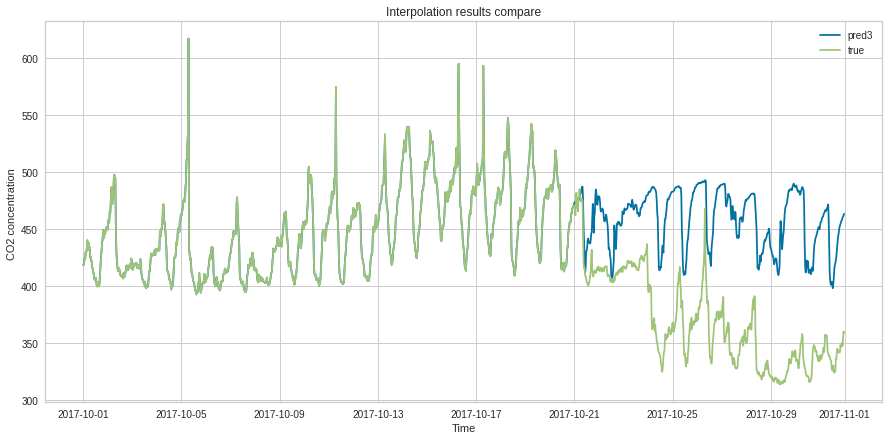

In [95]:
prev_data=data[train_indexing][['timestamp','CO2']].rename(columns={'CO2':"pred3"}).set_index('timestamp')
prev_data['true']=prev_data['pred3']

# plot
to_plot=pd.concat([prev_data,results])
plt.figure(figsize=(15,7))
plt.xlabel("Time")
plt.ylabel("CO2 concentration ")
plt.title("Interpolation results compare")
plt.plot(to_plot)
plt.legend(to_plot.columns)
plt.show()

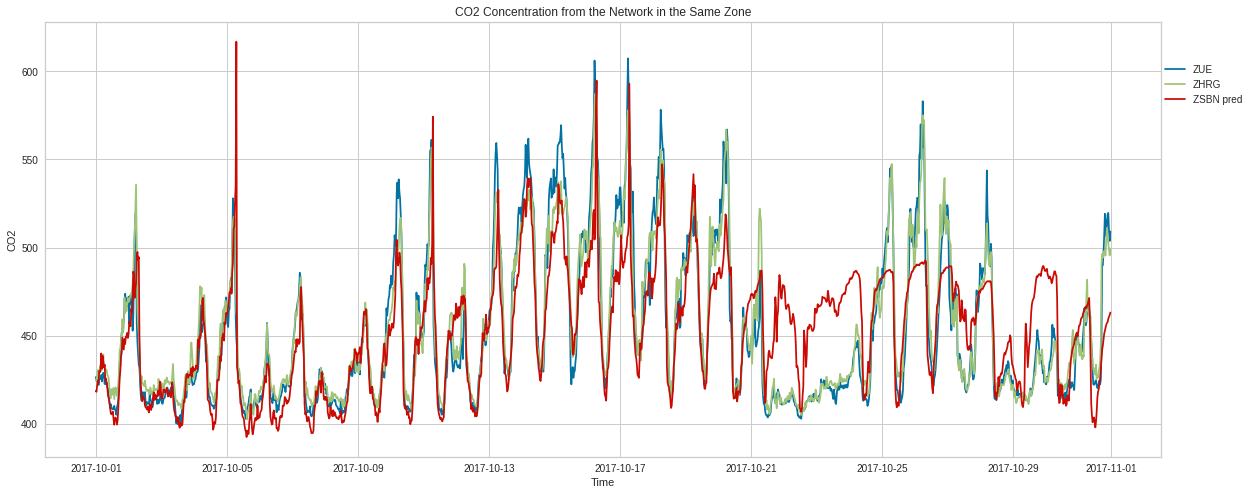

In [96]:
# compare with other sensors which have similar co2 concentration to ZSBN
data_zsbn_same_cluster = data[data['zone'] == data_zsbn['zone'].unique()[0]]
plt.figure(figsize = (20, 8))
for location in ['ZUE','ZHRG']:
    co2_loc = data_zsbn_same_cluster[data_zsbn_same_cluster['LocationName'] == location].loc[:, 'CO2']
    plt.plot(co2_loc, label = location)
    
plt.plot(to_plot.loc[:,'pred3'],label='ZSBN pred')
# plt.plot(to_plot.loc[:,'true'],label='ZSBN true',color='pink')
plt.xlabel('Time')
plt.ylabel('CO2')
plt.title('CO2 Concentration from the Network in the Same Zone')
plt.legend(loc = (1, 0.8))
plt.show()

#### Explaination:

- This model has much wider confidence interval. However, the R square is much lower and it may because of the same the reason mentioned above.
- Generally, it gives higher CO2 concentration prediction compared to the previous one, which are all above 400 and with peaks close to 500.
- Although the trend seems to be similar to the previous prediction, the pointwise difference between other sensors becomes smaller.(Values of ZSBN before drifting are similart to these two sensors, so their point-wise difference should be small)

f) **5/35** Redo the question e) with [statsmodels](https://www.statsmodels.org/stable/index.html), a moudle for statistical models with an extensive list of result statistics. Build the linear regression model with statsmodels and examine the result statistics; keep features whose p-value are strictly less than 0.05 and build a new model. Plot and compare the actual CO2 measurements, the values obtained by the prediction of the new model for the entire month of October. Discuss your findings.

__Note__: This introduciton page of [Linear Regression](https://www.statsmodels.org/stable/regression.html) may be helpful to you.

In [97]:
X_added_cste = sm.add_constant(X) # adding a constant

model = sm.OLS(y,X_added_cste ).fit()
predictions = model.predict(X_added_cste) 

print_model = model.summary()
print(print_model)

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.417
Model:                            OLS   Adj. R-squared:                  0.413
Method:                 Least Squares   F-statistic:                     96.88
Date:                Tue, 07 Apr 2020   Prob (F-statistic):          4.49e-210
Time:                        13:37:02   Log-Likelihood:                -9399.8
No. Observations:                1908   AIC:                         1.883e+04
Df Residuals:                    1893   BIC:                         1.891e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        206.8567     12.925     16.004      0.0

In [98]:
# prediction
X_reduit=X[:,[0,6,7,13]]
lasso = linear_model.Lasso().fit(X_reduit,y)
X_test_reduit=X_test[:,[0,6,7,13]]
y_pred4=lasso.predict(X_test_reduit)
results=pd.DataFrame(y_true,y_pred4).reset_index().rename(columns={0:'timestamp',1:'true','index':'pred4'})\
[['timestamp','pred4','true']].set_index('timestamp')
results.head()

,pred4,true
timestamp,,
2017-10-21 00:00:00,480.298100,469.545
2017-10-21 00:30:00,481.090989,466.991
2017-10-21 01:00:00,480.877507,461.869
2017-10-21 01:30:00,481.115424,477.921
2017-10-21 02:00:00,479.447590,481.693


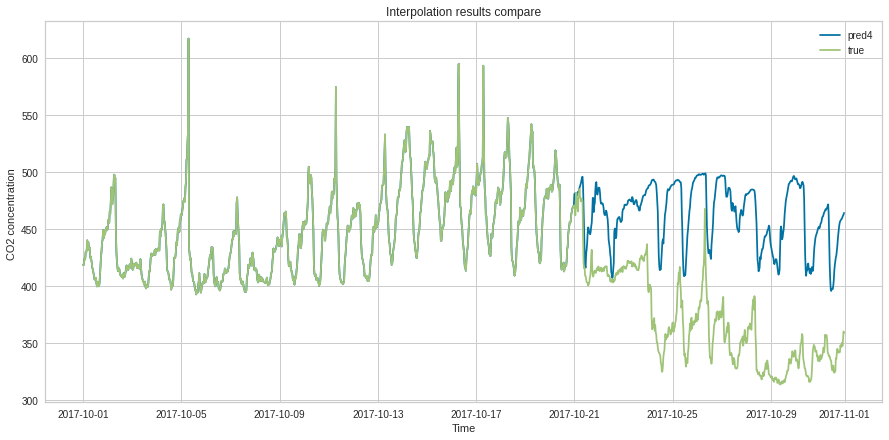

In [99]:
# plot
prev_data=data[train_indexing][['timestamp','CO2']].rename(columns={'CO2':"pred4"}).set_index('timestamp')
prev_data['true']=prev_data['pred4']
to_plot=pd.concat([prev_data,results])
plt.figure(figsize=(15,7))
plt.xlabel("Time")
plt.ylabel("CO2 concentration ")
plt.title("Interpolation results compare")
plt.plot(to_plot)
plt.legend(to_plot.columns)
plt.show()

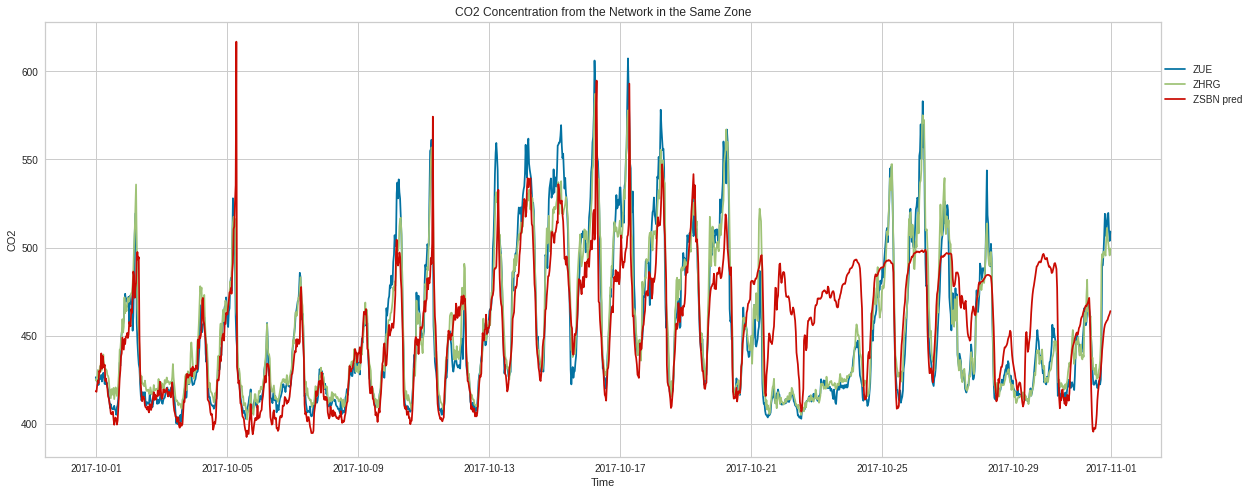

In [100]:
# Compare with other sensors which have similar co2 concentration to ZSBN
data_zsbn_same_cluster = data[data['zone'] == data_zsbn['zone'].unique()[0]]
plt.figure(figsize = (20, 8))
for location in ['ZUE','ZHRG']:
    co2_loc = data_zsbn_same_cluster[data_zsbn_same_cluster['LocationName'] == location].loc[:, 'CO2']
    plt.plot(co2_loc, label = location)
    
plt.plot(to_plot.loc[:,'pred4'],label='ZSBN pred')
plt.xlabel('Time')
plt.ylabel('CO2')
plt.title('CO2 Concentration from the Network in the Same Zone')
plt.legend(loc = (1, 0.8))
plt.show()

#### Explaination:

- From the plot, we can observe that selecting features according to statisitcs result reveal a similar prediction to using linar regression. 
- They all have similar changing trend.
- And the predicted concentration stay in the same range (400-500) except that the predicted value is below 400 at the one moment prior to NOV. 1.

g) **10/35** In this question, we will use __Bayesian Structural Time Serie Modelling__ to reconstruct counterfactual values, that is, what the CO2 measurements of the faulty sensor should have been, had the malfunction not happened on October 21.  We will use the information of provided by similar sensors (the ones you identified in the previous question), together with the covariates associated with the faulty sensors that were not affected by the malfunction (such as temperature and humidity).

To answer this question, you can choose between a Python port of the CausalImpact package (such as https://github.com/dafiti/causalimpact) or the original R version (https://google.github.io/CausalImpact/CausalImpact.html) that you can run in your notebook via an R kernel (https://github.com/IRkernel/IRkernel).

Before you start, watch first the [presentation](https://www.youtube.com/watch?v=GTgZfCltMm8) given by Kay Brodersen (one of the creators of the causal impact implementation in R), and this introductory [ipython notebook](http://nbviewer.jupyter.org/github/dafiti/causalimpact/blob/master/examples/getting_started.ipynb) with examples of how to use the python package.


Is the counterfactual reconstruction of CO2 measurements significantly different from the observed measurements?

In [103]:
from causalimpact import CausalImpact

# combine similar conditions from the sensors 
temp_humid_alt_zue = data[data['LocationName'] == 'ZUE'][['temperature', 'humidity']].rename(columns = {'temperature': 'temp_zue', 'humidity': 'humid_zue'})
temp_humid_alt_zhrg = data[data['LocationName'] == 'ZHRG'][['temperature', 'humidity']].rename(columns = {'temperature': 'temp_zhrg', 'humidity': 'humid_zhrg'})
conditions = pd.concat([pd.concat([data_zsbn[['CO2', 'temperature', 'humidity']], temp_humid_alt_zue], axis = 1), temp_humid_alt_zhrg], axis = 1)

# perform causal impact
pre_period = ['2017-10-01 00:00:00', '2017-10-20 23:30:00']
post_period = ['2017-10-21 00:00:00', '2017-10-31 23:30:00']
ci = CausalImpact(conditions, pre_period, post_period)

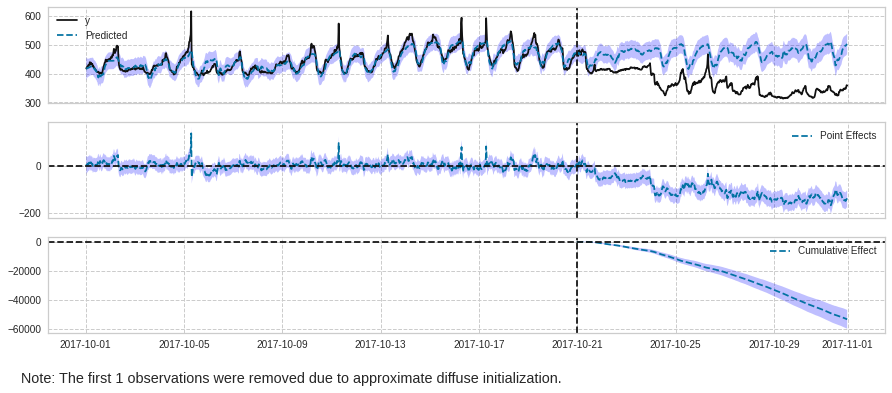

In [158]:
#plot
ci.plot(figsize=(15, 6))

In [104]:
print(ci.summary())
print(ci.summary(output = 'report'))

Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    369.26             194968.44
Prediction (s.d.)         470.57 (6.22)      248459.87 (3281.9)
95% CI                    [458.67, 483.04]   [242180.08, 255044.88]

Absolute effect (s.d.)    -101.31 (6.22)     -53491.42 (3281.9)
95% CI                    [-113.78, -89.42]  [-60076.44, -47211.64]

Relative effect (s.d.)    -21.53% (1.32%)    -21.53% (1.32%)
95% CI                    [-24.18%, -19.0%]  [-24.18%, -19.0%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))
Analysis report {CausalImpact}


During the post-intervention period, the response variable had
an average value of approx. 369.26. By contrast, in the absence of an
intervention, we would have expected an average response of 470.57.
The 95% interval of this counterfactual prediction is [458.67, 483.04].
Subtrac

#### Explanation:

- Yes, the counterfactual reconstruction is significantly different from the observed measurement.
- We could see that based on the posterior tail-area probability (p-value), which is 0 in our case and definitely rejects the H0 assumption.
- Also, the build-in report suggests the causal effect is statistically significantly.

h) **Bonus (5):** Remove the drift with an advanced machine learning model of your choice. Discuss the results. 

Here we would like to apply **XGBoost** to remove the drift. **XGBoost** is a decision-tree-based ensemble machine learning algorithm that uses a gradient boosting framework. It has numerous advantages over other methods such as high execution speed and outstanding model performance. Thus, we implement this method using the well developed library `xgboost` to help us predict the CO2 concentration after Oct. 21 and remove the drift in the end.

First, we divide the data into training and testing data on the date Oct. 21. Data before Oct. 21 is used for training, while the rest is for testing.

In [177]:
# xgboost
import xgboost as xgb
from xgboost import plot_importance, plot_tree

# split data by the date 2017-10-21
split_date1 = pd.to_datetime('2017-10-21 00:00:00')
co2_zsbn_before_21 = data_zsbn['CO2'].loc[data_zsbn.index < split_date1].copy()
co2_zsbn_after_21 = data_zsbn['CO2'].loc[data_zsbn.index >= split_date1].copy()

# divide data before 10-21 into training and validation set by the date 2017-10-17
split_date2 = pd.to_datetime('2017-10-17 00:00:00')
co2_zsbn_train = co2_zsbn_before_21.loc[co2_zsbn_before_21.index < split_date2].copy()
co2_zsbn_val = co2_zsbn_before_21.loc[co2_zsbn_before_21.index >= split_date2].copy()

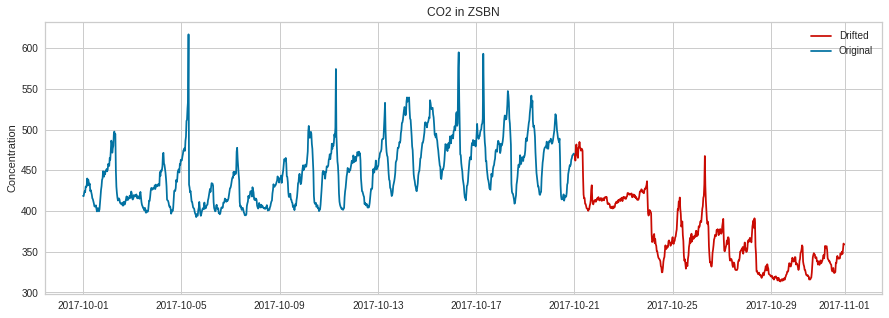

In [178]:
 # visualize
plt.figure(figsize = (15, 5))
plt.plot(co2_zsbn_after_21.index, co2_zsbn_after_21, c = 'r', label = 'Drifted')
plt.plot(co2_zsbn_before_21.index, co2_zsbn_before_21, label = 'Original')
plt.ylabel('Concentration')
plt.title('CO2 in ZSBN')
plt.legend()
plt.show()

 In addition, we split the training data based on Oct. 17. Before 17 the data is for training, while the data after 17 is for validation.

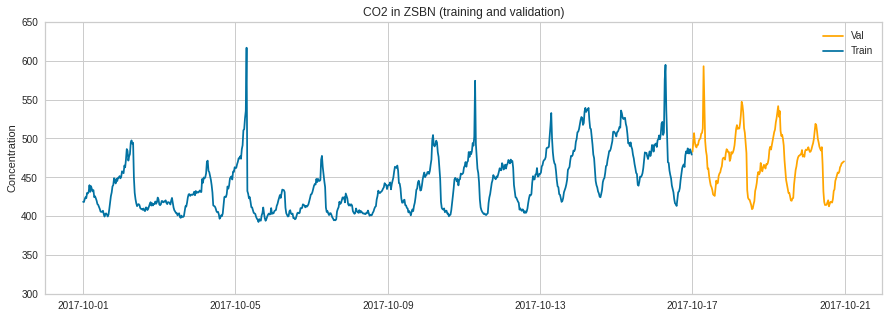

In [179]:
# visualize training and validation data
plt.figure(figsize = (15, 5))
plt.plot(co2_zsbn_val.index, co2_zsbn_val, c = 'orange', label = 'Val')
plt.plot(co2_zsbn_train.index, co2_zsbn_train, label = 'Train')
plt.ylabel('Concentration')
plt.title('CO2 in ZSBN (training and validation)')
plt.ylim((300, 650))
plt.legend()
plt.show()

 For machine learning task, we need features. Here we use date, temperature, and humidity as our features.

In [180]:
# create features using date, temperature, and humidity
def create_features(series, ref, label=None):
    df = pd.DataFrame(series)
    df['date'] = series.index.to_series()
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['dayofyear'] = df['date'].dt.dayofyear
    df['temperature'] = ref['temperature']
    df['humidity'] = ref['humidity']
    X = df[['hour','dayofweek', 'dayofyear', 'temperature', 'humidity']]
    if label:
        y = df[label]
        return X, y
    return X

In [181]:
# tranform co2 training and testing data into feature and label array
X_train, y_train = create_features(pd.DataFrame(co2_zsbn_train), data_zsbn, label = 'CO2')
X_val, y_val = create_features(pd.DataFrame(co2_zsbn_val), data_zsbn, label = 'CO2')
X_test, _ = create_features(pd.DataFrame(co2_zsbn_after_21), data_zsbn, label = 'CO2')

Since our goal is to predict CO2 concentration, we exploit XGBRegressor with 1000 decision trees for doing so. Then we would train it on training data and evaluating on validation data.

In [182]:
# perform XGBoost regressor for training
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)], early_stopping_rounds=10, verbose=False)

XGBRegressor(base_score=0.5, booster=None, colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints=None,
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=0, num_parallel_tree=1,
             objective='reg:squarederror', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method=None,
             validate_parameters=False, verbosity=None)

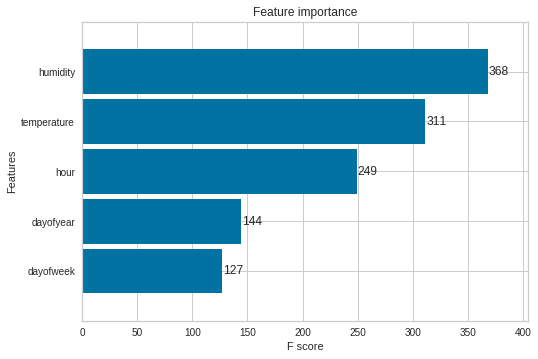

In [183]:
 # display feature importance
_ = plot_importance(reg, height=0.9)

After training, `humidity` and `temperature` are two most important features in CO2 prediction, showing that they are most commonly used for splitting the trees. hour turns out to be useful feature surprisingly.

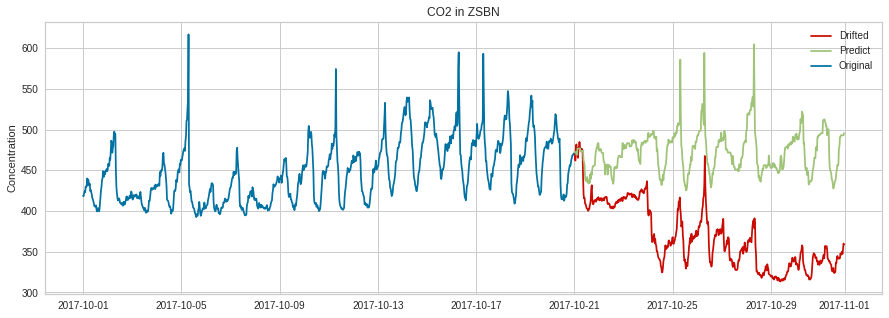

In [184]:
# make prediction on data after 10-21
prediction = pd.Series(reg.predict(X_test), index = X_test.index) 

plt.figure(figsize = (15, 5))
plt.plot(co2_zsbn_after_21.index, co2_zsbn_after_21, c = 'r', label = 'Drifted')
plt.plot(prediction.index, prediction, c = 'g', label = 'Predict')
plt.plot(co2_zsbn_before_21.index, co2_zsbn_before_21, label = 'Original')
plt.ylabel('Concentration')
plt.title('CO2 in ZSBN')
plt.legend()
plt.show()

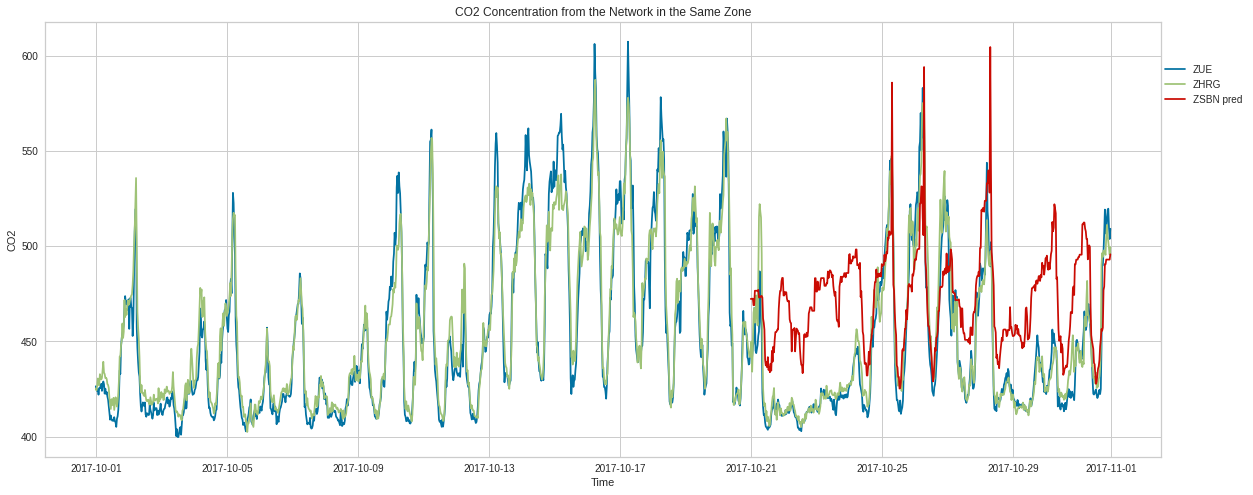

In [185]:
# compare with other sensors which have similar co2 concentration to ZSBN
data_zsbn_same_cluster = data[data['zone'] == data_zsbn['zone'].unique()[0]]
plt.figure(figsize = (20, 8))
for location in ['ZUE','ZHRG']:
    co2_loc = data_zsbn_same_cluster[data_zsbn_same_cluster['LocationName'] == location].loc[:, 'CO2']
    plt.plot(co2_loc, label = location)
    
plt.plot(prediction,label='ZSBN pred')
# plt.plot(co2_zsbn_after_21,label='ZSBN true',color='pink')
plt.xlabel('Time')
plt.ylabel('CO2')
plt.title('CO2 Concentration from the Network in the Same Zone')
plt.legend(loc = (1, 0.8))
plt.show()

#### Explaination: 
- **Xgbboost** gives a different prediction on the measurements than previous models, which shows differnt changing trend and flutuate more violently. And obviously, it fit the curve of other sensors better with less point-wise difference. (As mentioned before, values of ZSBN before drifting are similar to these two sensors, so their point-wise difference should be small)
- It predicts CO2 concentration mostly higher than 450 during period from 10-21 to 10-25 whereas previous models gave a result from 400 to 450 ppm. 
- Moreover, it sometimes predict very high the CO2 concentration, which are over 550 ppm after 10-25 but the previous models didn't give such predictions. 
- When compared with the co2 concentration with the ones detected by sensors in ZUE and ZHRG, the trend fit their curve better with this model from 10-24.